## Functions

In [1]:
%matplotlib inline
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from numpy.linalg import inv, det
from numpy import multiply
from math import exp
from scipy.stats import norm
import scipy as sp
from generate_regression_data import generate_regression_data
from scipy.stats import multivariate_normal as mn

In [2]:
# ML estimates
def ml_est_phi(x_vec, y_vec):
    """
    calculate the estimated phi values
    :param x_vec: np.mat. datapoints
    :param y_vec: np.mat. target values
    """
    return inv(x_vec * x_vec.T) * x_vec * y_vec

In [3]:
def ml_est_covar(x_vec, y_vec, phi, num_pts):
    return ((y_vec - x_vec.T * phi).T * (y_vec - x_vec.T * phi)) / num_pts

In [4]:
def map_est_phi(X, Y, covar, p_covar):
    """
    estimate MAP phi
    :param x_vec:
    :param y_vec:
    :param covar:
    :param p_covar: prior covariance
    :return:
    """
    return inv(X * X.T + (np.array(covar)[0] / p_covar) * np.identity(2)) * X * Y

In [5]:
# plot linear regression
def plot_reg(X, Y, X_vec, num_pts, phi, num_samples=250, title='', save=False, filename=''):
    if title:
        plt.title(title)
        
    data = np.array(sorted(zip(np.array(X).reshape(num_pts,), np.array(X_vec.T * phi).reshape(num_pts,)))).T
    
    xx = np.linspace(np.min(X), np.max(X), 250)
    f  = np.polyval(phi[::-1], xx) 
    plt.scatter(X, Y)
    plt.plot(xx, f, 'r')
    
    if save:
        plt.savefig(filename, dpi=500)

# data and graphs

In [6]:
num_pts = 20
p_covar = 0.8

# ##########
# pts_n = generate_data(num_pts, 0.4, 3, 'normal')

# x_vec_n = np.insert(np.mat(pts_n[0]), 0, [1 for i in range(num_pts)], axis=0)
# y_vec_n = np.mat(pts_n[1]).T

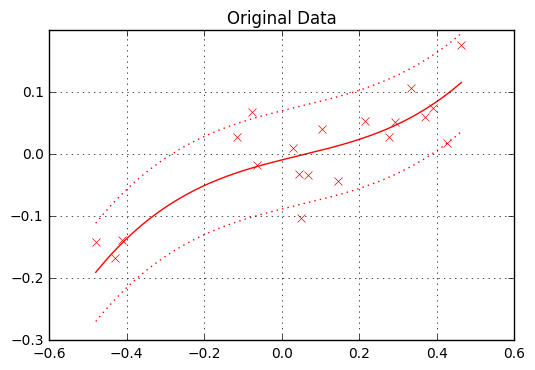

In [7]:
# generate some data
num_pts = 20
X_1, Y_1, true_equation_1, noise_std_1 = generate_regression_data(num_training_points=num_pts, 
                                                                  polynomial_order_of_data=3, 
                                                                  signal_to_noise_ratio=0.5, 
                                                                  num_input_dimensions=1,
                                                                  plot_data=True)

X_1_vec = np.mat(np.insert(X_1.T, 0, [1. for i in range(num_pts)], axis=0))

# Normal Data Fitting (ML)

In [8]:
# calculate the phi estimates
est_phi_1 = ml_est_phi(X_1_vec, Y_1)
print est_phi_1

[[-0.01848613]
 [ 0.25374817]]


In [9]:
# TODO: calculate the covariance estimates
# est_covar_n = np.multiply((y_vec_n - x_vec_n.T * est_phi_n).T, (y_vec_n - x_vec_n.T * est_phi_n))

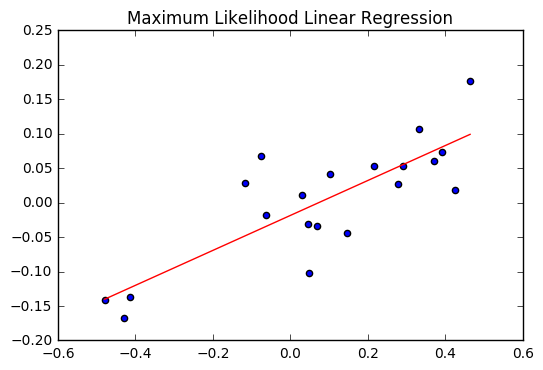

In [10]:
plot_reg(X_1, Y_1, X_1_vec, num_pts, est_phi_1,
         title='Maximum Likelihood Linear Regression',
         save=True, filename='write-up/tmp/lin-ml.png')
# plt.scatter(X_1, Y_1)
# xx = np.linspace(np.min(X_1), np.max(X_1), num_pts)
# plt.plot(np.array(X_1).reshape(num_pts,) , np.array(X_1_vec.T * est_phi_n).reshape(num_pts,),'r')

# MAP

In [11]:
# Use ML to get covar
est_covar_1 = ml_est_covar(X_1_vec, Y_1, est_phi_1, num_pts)
print est_covar_1

[[ 0.00247766]]


In [12]:
# MAP phi
p_covar = 0.8
map_est_phi_1 = map_est_phi(X=X_1_vec, Y=Y_1, covar=est_covar_1, p_covar=p_covar)
print map_est_phi_1

[[-0.01844101]
 [ 0.25323002]]


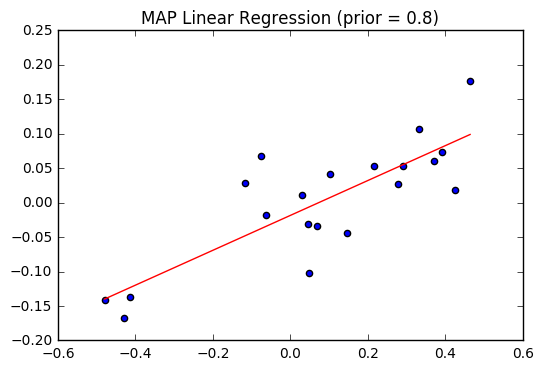

In [13]:
# plot MAP
plot_reg(X_1, Y_1, X_1_vec, num_pts, map_est_phi_1,
         title='MAP Linear Regression (prior = 0.8)',
         save=True,
         filename='write-up/tmp/lin-map-large.png')

# Bayesian Linear Regression

We compute the inverse using matrix inverse lemma, then the Bayesian Posterior paramters

In [14]:
# function - matrix inverse lemma to compute the inverse of A
def inv_a(x_vec, covar, p_covar, num_pts):
    a_inv_1 = p_covar * np.identity(x_vec.shape[0])
    a_inv_2_1 = p_covar * x_vec
    a_inv_2_2 = inv((x_vec.T * x_vec) + (np.array(covar)[0] / p_covar * np.identity(num_pts)))
    return a_inv_1 - a_inv_2_1 * a_inv_2_2 * x_vec.T

In [15]:
# Bayesian - posterior distribution parameters
def bayes_posterior_params(x_vec, y_vec, covar, p_covar, num_pts):
    # calculate a
    inverse = inv_a(x_vec, covar, p_covar, num_pts)
    
    # calculate normal distribution paramters
    posterior_mu = inverse * x_vec * y_vec / covar 
    posterior_covar = inverse
    return posterior_mu, posterior_covar

In [16]:
# Bayesian posterior distribution parameters
input_mu, input_covar = bayes_posterior_params(X_1_vec, Y_1, est_covar_1, p_covar, num_pts)
print 'input_mu\n{0}\n\ninput_covar\n{1}'.format(input_mu, input_covar)

----PDF----
input_mu
[[-0.01844101]
 [ 0.25323002]]

input_covar
[[ 0.00013466 -0.00013242]
 [-0.00013242  0.00162395]]


Bayesian Inferences

In [17]:
# Funciton - Bayesian predictive distribution parameters
def bayes_predict_params(X, Y, new_x, covar, p_covar, num_pts):
    inverse = inv_a(X, covar, p_covar, num_pts)
    predict_mu = new_x.T * inverse * X * Y / covar
    predict_covar = (new_x.T * inverse * new_x) + covar
    return predict_mu, predict_covar

In [18]:
# Function - Bayesian predictive distribution 
def bayes_predict_pdf(X, X_vec, Y, covar, p_covar, num_pts):
    # the x* points we are interested in predicting their w*'s
    pre_x = np.linspace(np.min(X), np.max(X), num_pts)
    pre_x_range_vec = np.mat([[1. for i in range(num_pts)], pre_x]).T # in the shape of the X vector
    
    # the w* which we'd like to give a probability for
    pre_y_range = np.linspace(np.min(Y), np.max(Y), num_pts) 

    # predictive pdf for each 
    pre_pdf = np.array([])
    for pt in range(num_pts):
        new_x = pre_x_range_vec[pt].T
        predict_mu, predict_covar = bayes_predict_params(X_vec, Y, new_x, covar, p_covar, num_pts)
        pre_pdf = np.append(pre_pdf, mn.pdf(pre_y_range, mean=np.array(predict_mu.T)[0], cov=predict_covar), axis=0)

    return pre_pdf.reshape(num_pts, num_pts) # reshape data to reflect each data point's distribution

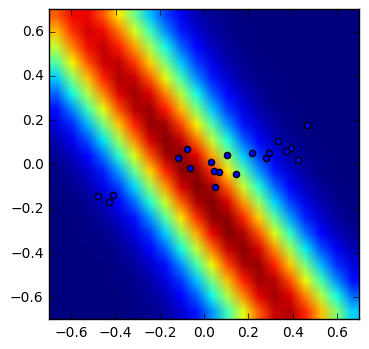

In [19]:
# We want to plot heatmap of P(w* | x*)
# Each pixel on the plot is coloured by the probability
# We need to evaluate P(w* | x*) at each pixel on the plot
 
pre_pdf = bayes_predict_pdf(X_1, X_1_vec, Y_1, est_covar_1, p_covar, num_pts)
pixels = np.zeros((20,20))  # 5x5 grid of points

for x in range(num_pts):
    for y in range(num_pts):
        pixels[x, y] = pre_pdf[x][y]

plt.scatter(X_1, Y_1)
plt.imshow(pixels, extent=[-0.7,0.7,-0.7,0.7])

# Non-linear regression using ML

In [20]:
# non-linear input matrix and gradients
z_2 = np.mat(np.array([[pt**i for i in range(3)] for pt in X_1]).T)
z_3 = np.mat(np.array([[1, pt, pt**2, pt**3] for pt in X_1]).T)
z_4 = np.mat(np.array([[1, pt, pt**2, pt**3, pt**4] for pt in X_1]).T)
z_10 = np.mat(np.array([[pt**i for i in range(11)] for pt in X_1]).T)
z_20 = np.mat(np.array([[pt**i for i in range(21)] for pt in X_1]).T)

phi_z_2 = ml_est_phi(z_2, Y_1)
phi_z_3 = ml_est_phi(z_3, Y_1)
phi_z_4 = ml_est_phi(z_4, Y_1)
phi_z_10 = ml_est_phi(z_10, Y_1)
phi_z_20 = ml_est_phi(z_20, Y_1)

# plt.scatter(X_1, Y_1)
# # # plt.plot(3.5,, 'bs')
# plt.plot(np.array(X_1).reshape(20,), 
#          np.array(z_10.T * phi_z_10).reshape(20,), 'r')

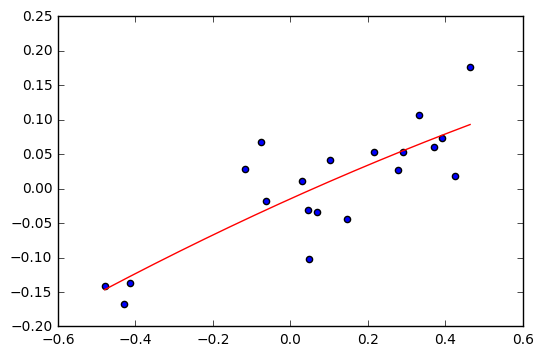

In [21]:
# plot non-linear - showing overfitting using a 2-degree polynomial ('linear')
plot_reg(X_1, Y_1, z_2, num_pts, phi_z_2,
        save=True,
        filename='write-up/tmp/non-degree-2.png')

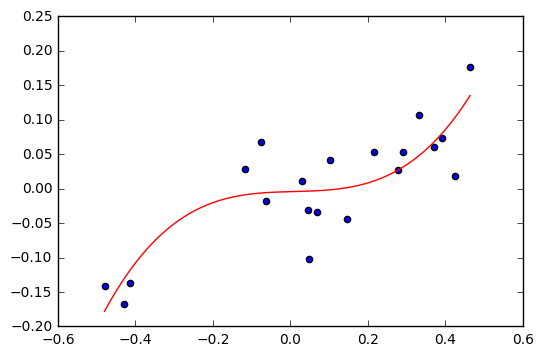

In [22]:
# plot non-linear - showing overfitting using a 3-degree polynomial
plot_reg(X_1, Y_1, z_3, num_pts, phi_z_3,
        save=True,
        filename='write-up/tmp/non-degree-3.png')

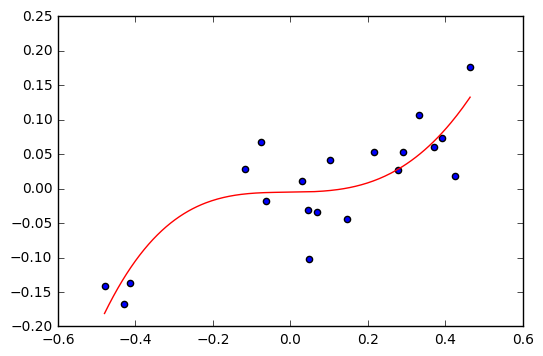

In [23]:
# plot non-linear - showing overfitting using a 4-degree polynomial ('linear')
plot_reg(X_1, Y_1, z_4, num_pts, phi_z_4,
        save=True,
        filename='write-up/tmp/non-degree-4.png')

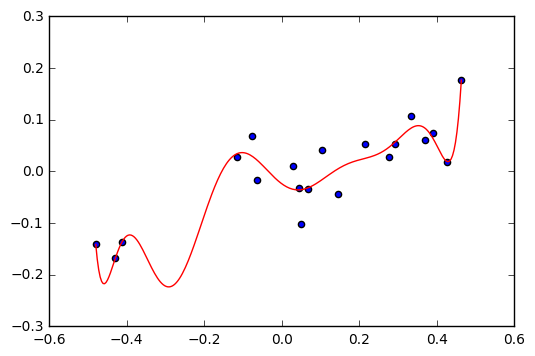

In [24]:
# plot non-linear - showing overfitting using a 10-degree polynomial ('linear')
plot_reg(X_1, Y_1, z_10, num_pts, phi_z_10,
        save=True,
        filename='write-up/tmp/non-degree-10.png')

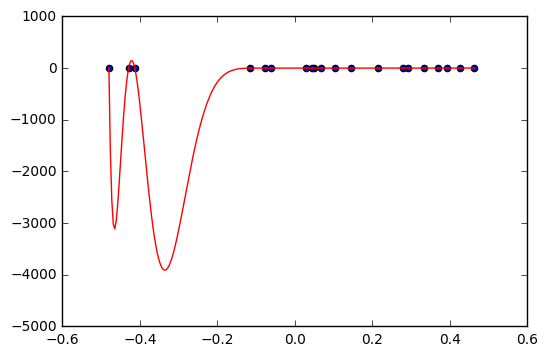

In [25]:
# plot non-linear - showing overfitting using a 20-degree polynomial
plot_reg(X_1, Y_1, z_20, num_pts, phi_z_20,
        save=True,
        filename='write-up/tmp/non-degree-20.png')